# Process meteorological data from https://api.met.no/

https://www.met.no/en/free-meteorological-data

In [25]:
from bs4 import BeautifulSoup
import urllib.request
from datetime import datetime, timedelta
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import dates

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set(style='white')

In [102]:
location_url = 'https://api.met.no/weatherapi/locationforecast/1.9/?lat=63.44&lon=10.37'

In [103]:
response = urllib.request.urlopen(location_url)
data = response.read()  
soup = BeautifulSoup(data,'lxml')

In [104]:
# Example wind dictionary
# {'beaufort': '2', 'id': 'ff', 'mps': '3.0', 'name': 'Svak vind'}

In [105]:
wind = {}
clouds_temp = {}
for forecast in soup.find_all(name='time'):
    if forecast.windspeed and forecast.areamaxwindspeed:
        wind[datetime.strptime(forecast.attrs['from'],'%Y-%m-%dT%H:%M:%SZ')] = [int(forecast.windspeed.attrs['beaufort']),
                                                                                float(forecast.windspeed.attrs['mps']),
                                                                                float(forecast.areamaxwindspeed.attrs['mps']),
                                                                                float(forecast.cloudiness.attrs['percent'])]
    elif forecast.precipitation and forecast.mintemperature:
        clouds_temp[datetime.strptime(forecast.attrs['from'],'%Y-%m-%dT%H:%M:%SZ')] = [float(forecast.mintemperature.attrs['value']),
                                                                                       float(forecast.maxtemperature.attrs['value']),
                                                                                       float(forecast.precipitation.attrs['value'])]
        

In [106]:
wind_pd = pd.DataFrame.from_dict(wind, orient='index', columns=['bft', 'mps', 'maxwind', 'cloudiness'])
temp_pd = pd.DataFrame.from_dict(clouds_temp, orient='index', columns=['min_temp', 'max_temp', 'precipitation'])
temp_pd['mean_temp'] = np.mean([temp_pd.min_temp, temp_pd.max_temp], axis=0)

In [107]:
def plot_data(wind_pd,temp_pd, sunset=21, sunrise=8):
    ''' Create plot from dataframe. Index has to be in timestamps'''
    sns.set(font_scale=1.1, style='white')
    figure = plt.figure(figsize=(20,4))
    ax = figure.add_subplot(111)

    ax.plot(wind_pd.index,wind_pd.bft, color='k', label='Beaufort', lw=2.5,alpha=.7)
    ax.plot(wind_pd.index,wind_pd.mps, label='m/s', ls=':', color='b')
    ax.plot(wind_pd.index,wind_pd.maxwind, label='m/s', ls=':', color='blue',alpha=.2)
    ax.set_ylabel('Wind speed')
    for time in wind_pd.index:
        if (time.hour > sunset) or (time.hour < sunrise):
            ax.axvspan(time, time + timedelta(hours=1), alpha=0.1, color='grey', lw=0)
    ax.set_ylim(0,5.5)      
    plt.xticks(rotation='45')

    ax2 = ax.twinx()  
    ax2.plot(wind_pd.index,wind_pd.cloudiness, label='Cloudiness',color='g',lw=4,alpha=.4)
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_ylabel('Cloudiness [%]')

    hfmt = dates.DateFormatter('%a %H:%M')
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.set_major_formatter(hfmt)
    ax.set_xlim(wind_pd.index[0], wind_pd.index[-1])
    
    plt.title('Wind and cloudiness forecast (Norwegian Meteorological Institute)', size=15)
    sns.despine(left=True)
    xlims = ax.get_xlim() # Safe here to transfer to next figure
    
    ###############################################################################################
    
    figure = plt.figure(figsize=(20,4))
    ax = figure.add_subplot(111)
    ax.fill_between(temp_pd.index, temp_pd.min_temp, temp_pd.max_temp, facecolor='r', alpha=.5)
    ax.plot(temp_pd.index,temp_pd.mean_temp, color='red', lw=2.5,alpha=.8)
    ax.set_ylabel('Temperature min max [C]')
    
    for time in temp_pd.index:
        if (time.hour > sunset) or (time.hour < sunrise):
            ax.axvspan(time, time + timedelta(hours=1), alpha=0.1, color='grey', lw=0)
    ax.set_ylim(0,30)      
    plt.xticks(rotation='45')

    ax2 = ax.twinx()  
    ax2.plot(temp_pd.index,temp_pd.precipitation, label='Precipitation',color='b',lw=4,alpha=.8)
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.set_ylabel('Precipitation [mm]')
    ax2.set_ylim(-1,20)
    hfmt = dates.DateFormatter('%a %H:%M')
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.set_major_formatter(hfmt)
    ax.set_xlim(xlims[0], xlims[1])
    
    plt.title('Temperature and precipitation forecast', size=15)
    sns.despine(left=True)

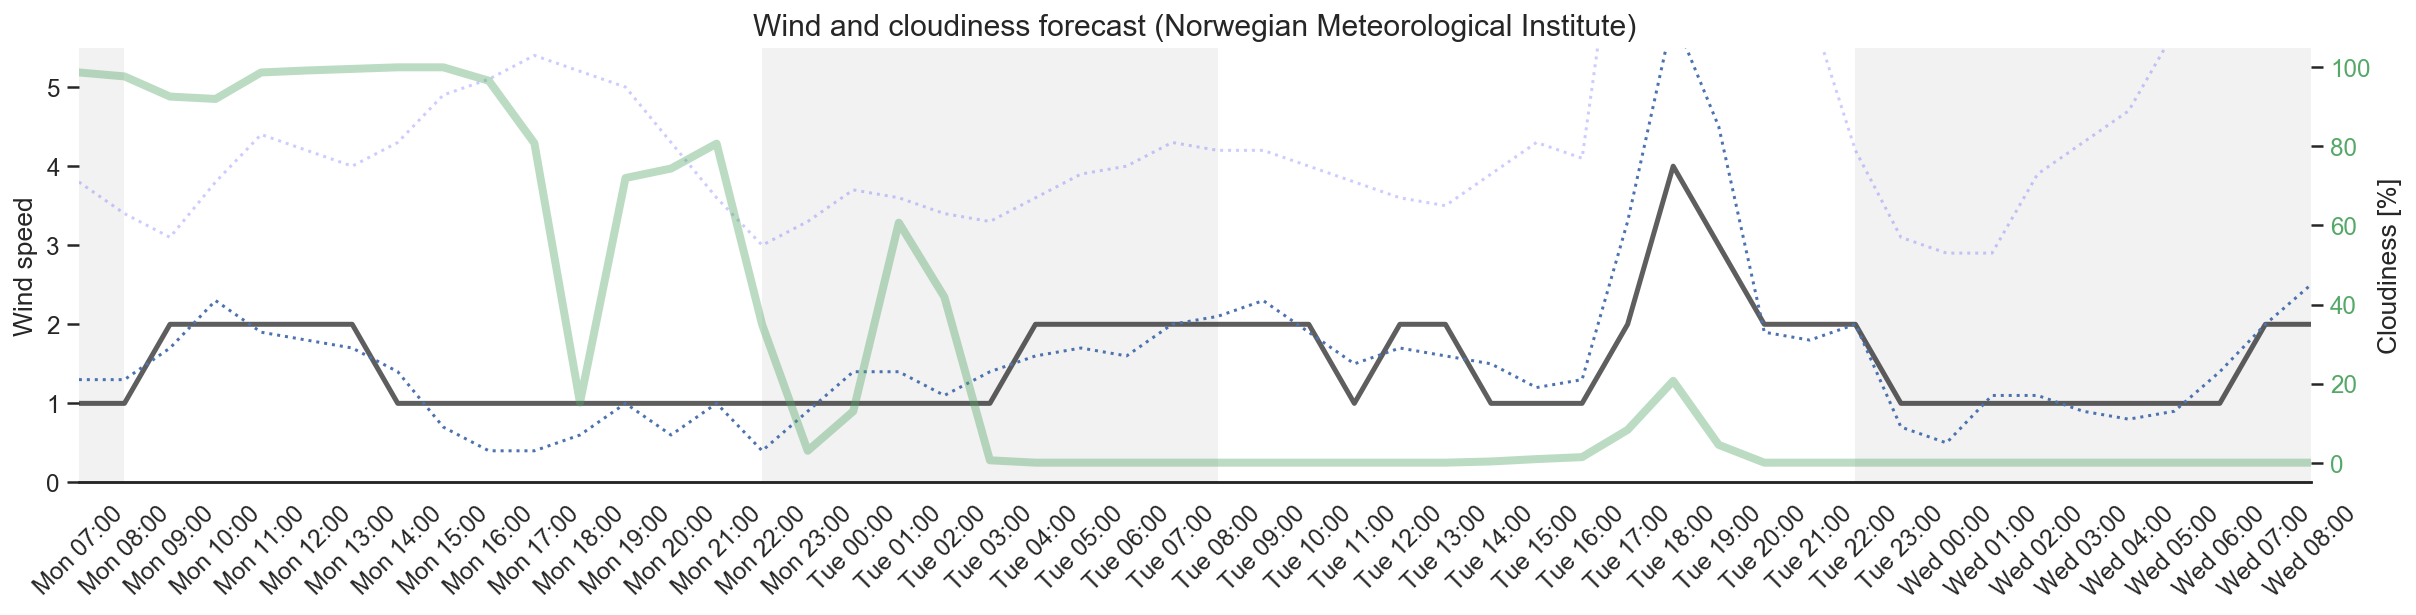

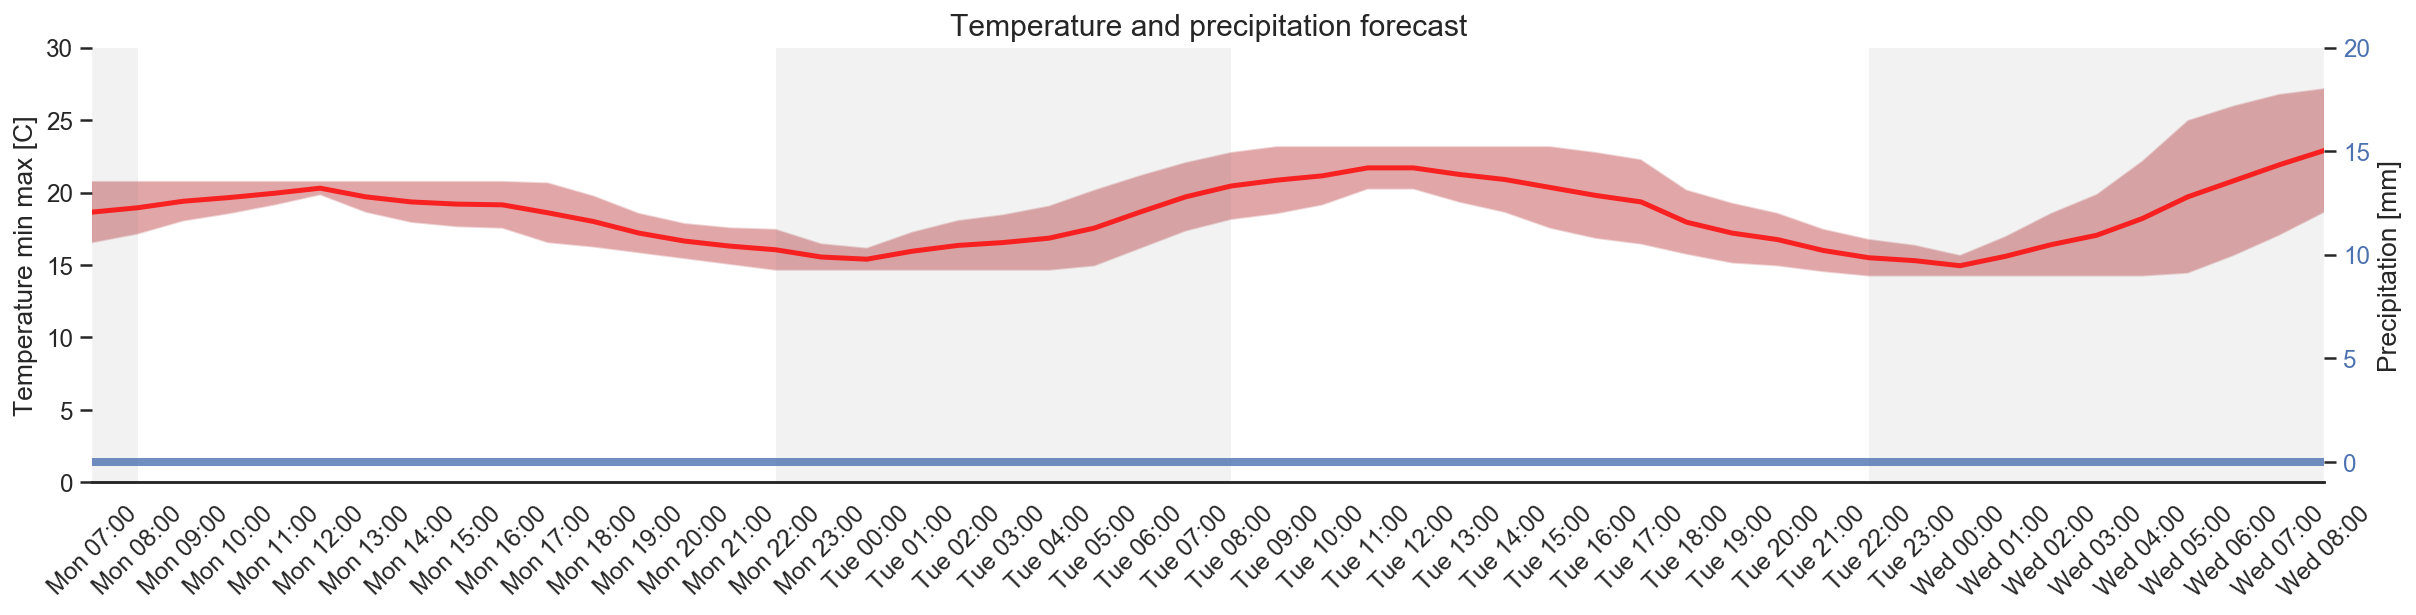

In [108]:
plot_data(wind_pd.iloc[:50],temp_pd.iloc[:60])